## IMDB reviews classifier.


This notebook is just a continuation of the other notebook, with this one I wanted to bring the preprocessing of the data into the model.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split


import nltk
from nltk.tokenize import word_tokenize
from nltk import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords



# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# visualisation 
import seaborn as sns
import matplotlib.pyplot as plt

Num GPUs Available:  1


In [2]:
PATH = "D:\DataSets\IMDB reviews"

In [3]:
df = pd.read_csv(PATH + "\\IMDB Dataset.csv")

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
decode_map = {"negative": 0, "positive":1}

def encode_sentiment(sentiment):
    return decode_map[sentiment]

df['label'] = df['sentiment'].apply(lambda x: encode_sentiment(x))

In [6]:
X = df['review']
y = df['label']

In [7]:
%%time
# split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=12)

Wall time: 4.99 ms


In [11]:
@tf.keras.utils.register_keras_serializable()
def custom_standardization(input_string):
    """ Remove html line-break tags and handle punctuation """
    lower = tf.strings.lower(input_string, encoding="utf-8")
    no_break = tf.strings.regex_replace(lower,"<br />"," ")
    only_words = tf.strings.regex_replace(no_break, "[^\w\s]"," ")

    #remove stop words
    no_stop_words = ' '+only_words+ ' '
    stop_words = stopwords.words('english')
    for each in stop_words:
        no_stop_words = tf.strings.regex_replace(no_stop_words, ' '+each+' ' , r" ")
    no_extra_space = tf.strings.regex_replace(no_stop_words, " +"," ")

    return no_extra_space

In [12]:
print("input:  ", test)
output_string= custom_standardization(test)
print()
print("output: ", output_string.numpy().decode("utf-8"))

input:   Husband-and-wife doctor team Carole and Niles Nelson are doing modestly well in their careers, but Niles has a gambling problem. His luck changes when he (unknowingly) saves the life of a gangster from Joe Gurney's mob and gets a big bonus from the gangleader himself. Loving his change of fortune (and snazzy new apartment), Niles continues to receive payoffs for patching up other injured members of the gang. Unfortunately, his shady deals come to light in a police raid, which hangs a shadow over his wife's career as well.<br /><br />At this point the plot comes into focus, as Carole Nelson has to rescue her career before her license is suspended. This involves bringing the gang to justice more or less single- handedly. <br /><br />This is not a hard-edged gangster picture, but a plot that might have been comfortable on a show like MATLOCK or MURDER SHE WROTE. There is some tension, but the mood is kept light by Bogart's tongue-in-cheek performance of a stupid gangster who imag

In [13]:
max_features = 20000 # only concider the top 20k words
max_length = 250 # max size of review length

In [14]:
# Create a vectorization layer and adapt it to the text
encoder = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    ngrams=(1),
    pad_to_max_tokens=True,
    output_mode="int",
    output_sequence_length=max_length,
)

In [15]:
# TextVectorization?

In [16]:
# prepare Tensorflow Datasets
# we convert the data stored in pandas data frame into a data sorted in thensorflow data set

x_train = tf.data.Dataset.from_tensor_slices(tf.cast(X_train.values, tf.string))

In [17]:
x_train

<TensorSliceDataset shapes: (), types: tf.string>

In [19]:
encoder.adapt(x_train)
vocab = encoder.get_vocabulary()

In [20]:
print(vocab[:20])

['', '[UNK]', 'movie', 'film', 'one', 'like', 'good', 'time', 'even', 'would', 'really', 'story', 'see', 'well', 'much', 'get', 'bad', 'great', 'also', 'people']


In [22]:
len(vocab)

20000

In [23]:
# defining our model

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1, ), dtype=tf.string, name="string"),
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True,dropout=0.5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    # to prevent overfitting
    tf.keras.layers.Dropout(0.5),
    # classification layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [24]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 250)               0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 64)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 250, 128)          66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [26]:
num_epochs = 10
history = model.fit(X_train, y_train, epochs=num_epochs,batch_size=512, validation_data=(X_test, y_test))

Epoch 1/10
79/79 [==============================] - 39s 400ms/step - loss: 0.6928 - accuracy: 0.5179 - val_loss: 0.6917 - val_accuracy: 0.5900
Epoch 2/10
79/79 [==============================] - 30s 376ms/step - loss: 0.6733 - accuracy: 0.6279 - val_loss: 0.5401 - val_accuracy: 0.7732
Epoch 3/10
79/79 [==============================] - 30s 380ms/step - loss: 0.4081 - accuracy: 0.8418 - val_loss: 0.3105 - val_accuracy: 0.8758
Epoch 4/10
79/79 [==============================] - 30s 380ms/step - loss: 0.2854 - accuracy: 0.8999 - val_loss: 0.2825 - val_accuracy: 0.8878
Epoch 5/10
79/79 [==============================] - 31s 395ms/step - loss: 0.2418 - accuracy: 0.9205 - val_loss: 0.2727 - val_accuracy: 0.8905
Epoch 6/10
79/79 [==============================] - 30s 385ms/step - loss: 0.2106 - accuracy: 0.9331 - val_loss: 0.2748 - val_accuracy: 0.8921
Epoch 7/10
79/79 [==============================] - 30s 381ms/step - loss: 0.1900 - accuracy: 0.9420 - val_loss: 0.2839 - val_accuracy: 0.8951

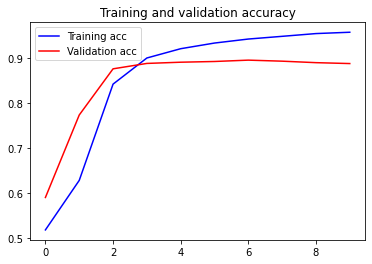

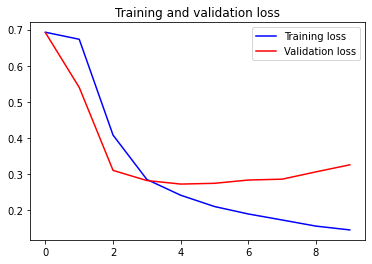

In [27]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 11s 34ms/step - loss: 0.3259 - accuracy: 0.8875


[0.3259217143058777, 0.887499988079071]

In [29]:
test = df.iloc[0]['review']
df.iloc[0]

review       One of the other reviewers has mentioned that ...
sentiment                                             positive
label                                                        1
Name: 0, dtype: object

In [30]:
model.predict([test])

array([[0.99190956]], dtype=float32)

In [31]:
test = df.iloc[3]['review']
df.iloc[3]

review       Basically there's a family where a little boy ...
sentiment                                             negative
label                                                        0
Name: 3, dtype: object

In [32]:
model.predict([test])

array([[0.08202595]], dtype=float32)

In [33]:
pred = model.predict(X_test).round()

In [34]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88      5017
           1       0.86      0.93      0.89      4983

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



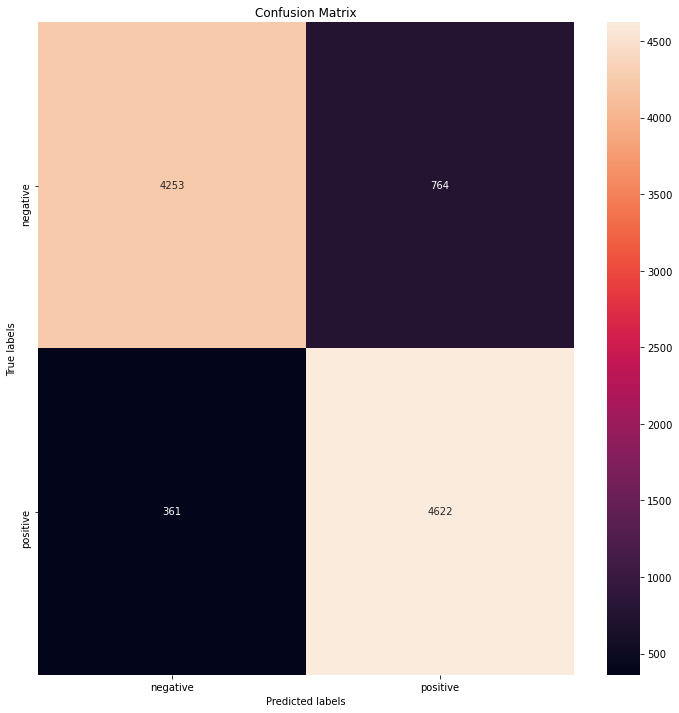

In [35]:
cm  = confusion_matrix(y_test, pred)
plt.figure(figsize=(12,12))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['negative', 'positive']); ax.yaxis.set_ticklabels(['negative', 'positive']);

In [36]:
test = "that movie was so so meh"

In [37]:
model.predict([test])

array([[0.61781484]], dtype=float32)

In [38]:
test = "really good movie"

In [39]:
model.predict([test])

array([[0.8662032]], dtype=float32)

In [41]:
# save model
filepath = "model"
model.save(filepath, save_format="tf")

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [42]:
# loaded_vectorize_layer_model = tf.keras.models.load_model(filepath)